Importing all required dependencies

In [67]:
from itertools import product
from collections import defaultdict
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
import pulp
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import json

Importing Word2Vec model (https://code.google.com/archive/p/word2vec/). The next block may require a long time!

In [68]:
wvmodel = gensim.models.KeyedVectors.load_word2vec_format(r'GoogleNews-vectors-negative300.bin', binary=True)

Testing Word2Vec model (@Mario: Nota quanto cazzo è incredibile sta cosa)

In [69]:
x_test = wvmodel['man']+wvmodel['king']-wvmodel['woman']
y_test = wvmodel['queen']
z_test = wvmodel['boat']

In [70]:
print(cosine_similarity([x_test], [y_test]))
print(cosine_similarity([x_test], [z_test]))

[[0.4057604]]
[[0.01503608]]


Here we initialize the collection&nbsp;. https://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.html &nbsp;
We use the smaller dataset (called mini). We tokenize all documents and assign to every document an unique ID and a label (depending on the group it came from). 

In [71]:
# To do, parse all documents and get the list of tokens (We remove capital letters?)

Useful functions

In [72]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [73]:
def dot_product_lists(a,b):
    return sum([x*y for x,y in zip(a,b)])

In [74]:
def wme_to_wmd(x,y,gamma):
    kxy = dot_product_lists(x,y)
    return -1/gamma*np.log(kxy)

Implementation of Word Mover Distance (solved through LP). Next two blocks from: https://github.com/stephenhky/PyWM

In [75]:
def tokens_to_fracdict(tokens):
    cntdict = defaultdict(lambda : 0)
    for token in tokens:
        cntdict[token] += 1
    totalcnt = sum(cntdict.values())
    return {token: float(cnt)/totalcnt for token, cnt in cntdict.items()}

In [ ]:
# UBER MEGA FAST WMD BY AL

from gensim.corpora.dictionary import Dictionary
def wmdistance(document1, document2, wvmodel):
        from pyemd import emd

        # Remove out-of-vocabulary words.
        len_pre_oov1 = len(document1)
        len_pre_oov2 = len(document2)
        remember_me = document2
        document2 = ['__qxvca^&3fd?#_!$' +  str(i) for i in range(len(document2))]
        diff1 = len_pre_oov1 - len(document1)
        diff2 = len_pre_oov2 - len(document2)
        if diff1 > 0 or diff2 > 0:
            logger.info('Removed %d and %d OOV words from document 1 and 2 (respectively).', diff1, diff2)

        if not document1 or not document2:
            logger.info(
                "At least one of the documents had no words that were in the vocabulary. "
                "Aborting (returning inf)."
            )
            return float('inf')

        dictionary = Dictionary(documents=[document1, document2])
        vocab_len = len(dictionary)

        if vocab_len == 1:
            # Both documents are composed by a single unique token
            return 0.0

        # Sets for faster look-up.
        docset1 = set(document1)
        docset2 = set(document2)

        wordvecs_random = {document2[i]: remember_me[i] for i in range(len(remember_me))}

        # Compute distance matrix.
        distance_matrix = np.zeros((vocab_len, vocab_len))
        for i, t1 in dictionary.items():
            if t1 not in docset1:
                continue

            for j, t2 in dictionary.items():
                if t2 not in docset2 or distance_matrix[i, j] != 0.0:
                    continue

                # Compute Euclidean distance between word vectors.
                distance_matrix[i, j] = distance_matrix[j, i] = np.sqrt(sum((wvmodel[t1] - wordvecs_random[t2])**2))

        def nbow(document):
            d = np.zeros(vocab_len)
            nbow = dictionary.doc2bow(document)  # Word frequencies.
            doc_len = len(document)
            for idx, freq in nbow:
                d[idx] = freq / float(doc_len)  # Normalized word frequencies.
            return d

        # Compute nBOW representation of documents.
        d1 = nbow(document1)
        d2 = nbow(document2)

        # Compute WMD.
        return emd(d1, d2, distance_matrix)

In [76]:
def word_mover_distance_probspec(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=None):
    all_tokens = list(set(first_sent_tokens+second_sent_tokens))
    wordvecs = {token: wvmodel[token] for token in all_tokens}

    first_sent_buckets = tokens_to_fracdict(first_sent_tokens)
    second_sent_buckets = tokens_to_fracdict(second_sent_tokens)

    T = pulp.LpVariable.dicts('T_matrix', list(product(all_tokens, all_tokens)), lowBound=0)

    prob = pulp.LpProblem('WMD', sense=pulp.LpMinimize)
    prob += pulp.lpSum([T[token1, token2]*euclidean(wordvecs[token1], wordvecs[token2])
                        for token1, token2 in product(all_tokens, all_tokens)])
    for token2 in second_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token1 in first_sent_buckets])==second_sent_buckets[token2]
    for token1 in first_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token2 in second_sent_buckets])==first_sent_buckets[token1]

    if lpFile!=None:
        prob.writeLP(lpFile)

    prob.solve()

    return prob

In [77]:
def WMD_regular(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=None):
    prob = word_mover_distance_probspec(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=lpFile)
    return pulp.value(prob.objective)

We need to define WMD also for a random document with random words

In [78]:
def word_mover_distance_random(documents_token, random_document_vectors, wvmodel, lpFile=None):
    #We create a random association between the random_document_vectors and tokens, assuming random vectors to be all different
    first_sent_tokens = documents_token
    second_sent_tokens = ['__qxvca^&3fd?#_!$' +  str(i) for i in range(len(random_document_vectors))]
    
    all_tokens = list(set(first_sent_tokens+second_sent_tokens))
    wordvecs_document = {token: wvmodel[token] for token in first_sent_tokens}
    wordvecs_random = {second_sent_tokens[i]: random_document_vectors[i] for i in range(len(random_document_vectors))}
    #print(wordvecs_random)
    wordvecs = merge_two_dicts(wordvecs_document,wordvecs_random)

    first_sent_buckets = tokens_to_fracdict(first_sent_tokens)
    second_sent_buckets = tokens_to_fracdict(second_sent_tokens)

    T = pulp.LpVariable.dicts('T_matrix', list(product(all_tokens, all_tokens)), lowBound=0)

    prob = pulp.LpProblem('WMD', sense=pulp.LpMinimize)
    prob += pulp.lpSum([T[token1, token2]*euclidean(wordvecs[token1], wordvecs[token2])
                        for token1, token2 in product(all_tokens, all_tokens)])
    for token2 in second_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token1 in first_sent_buckets])==second_sent_buckets[token2]
    for token1 in first_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token2 in second_sent_buckets])==first_sent_buckets[token1]

    if lpFile!=None:
        prob.writeLP(lpFile)

    prob.solve()

    return prob

In [79]:
def WMD_random(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=None):
    prob = word_mover_distance_random(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=lpFile)
    return pulp.value(prob.objective)

Test WMD functions

In [80]:
print(WMD_regular(['hi','bye'],['see','you'],wvmodel))
print(WMD_random(['hi','bye'],[wvmodel['see'],wvmodel['you']],wvmodel))

3.6146241426467896
3.6146241426467896


Implementation of the WME 

In [81]:
def WME_phi(x,w,gamma,wvmodel):
    return np.exp( -gamma*WMD_random(x,w,wvmodel))

In [120]:
def calculate_WME(documents, D_max, R, wvmodel):
    # It must returns a list of text embeddings, i-th element being the embedding of the i-th document
    
    #Phase 1: Compute v_max and v_min
    v_values = [+9999,-9999] # [v_min,v_max]
    for doc in documents:
        for token in doc:
            for x in wvmodel[token]:
                v_values[0] = min(v_values[0],x)
                v_values[1] = max(v_values[1],x)
            
    print("[v_min, v_max] = "  + str(v_values))
    Z = []
    for j in range(R):
        print("R: " + str(j+1)+"/"+str(R))
        D = 1 + np.random.randint(D_max)
        random_doc = []
        for l in range(D):
            word = np.random.uniform(v_values[0],v_values[1],size=300)
            word = word*1/np.sqrt(sum(x*x for x in word))
            random_doc.append(word)
        to_add = [WME_phi(doc,random_doc,1.12,wvmodel) for doc in documents]
        #print("to_add" + str(to_add))
        Z.append(to_add)
    ret_Z = (1/(np.sqrt(R))*np.array(Z).T).tolist()
    return ret_Z
        
        
    

In [121]:
documents = [['the','sun','is','the','best','thing','in','the','world'],['i','love','watch','the','sun','it','burns','my','life']]

In [122]:
#It returns a list of k_max elements, iteratively picked using the farthest-first traversal algorithm
# The returned list [a_1, ..., a_(k_max)] containts the indexes of the picked element at every iteration (i.e. a_i is selected in the i-th iteration)
# documents in this case containts the (ordered) list of the embeddings of the documents
def k_center(documents,k_max):
    ret = []
    radius = []
    N = len(documents)
    first = np.random.randint(N)
    ret.append(first)
    
    dist = [euclidean(doc,documents[first]) for doc in documents] 
   
    radius.append(np.max(dist))
    for k in range(k_max-1):
        #Selection
        j = np.argmax(dist)
        ret.append(j)
        
        #Update
        dist = [min(dist[i], euclidean(documents[i],documents[j])) for i in range(N)]
       
        radius.append(np.max(dist))
    return ret,radius
        
        
        
    

In [123]:
import pickle
f = open('newsgroup_dataset.pckl','rb')
obj = pickle.load(f)
f.close()
name_dataset = obj[0]
train_R_X = obj[1]
train_R_Y = obj[2]

In [124]:
print(train_R_X[0])

['apollo', 'hp', 'com', 'red', 'herring', 'subject', 'unconventional', 'peace', 'proposal', 'article', 'apc', 'org', 'center', 'policy', 'research', 'cpr', 'apc', 'org', 'writes', 'center', 'policy', 'research', 'cpr', 'subject', 'unconventional', 'peace', 'proposal', 'unconventional', 'proposal', 'peace', 'middle', 'east', 'elias', 'stated', 'assumptions', 'state', 'proposal', 'fund', 'established', 'would', 'disburse', 'grants', 'child', 'born', 'couple', 'one', 'partner', 'israeli', 'jew', 'palestinian', 'arab', 'emergence', 'considerable', 'number', 'mixed', 'marriages', 'israel', 'palestine', 'would', 'relatives', 'sides', 'divide', 'would', 'make', 'conflict', 'lose', 'ethnical', 'core', 'strengthen', 'emergence', 'truly', 'civil', 'society', 'existence', 'strong', 'mixed', 'stock', 'people', 'would', 'also', 'help', 'integration', 'israeli', 'society', 'sounds', 'like', 'racial', 'theory', 'hitler', 'outlined', 'mein', 'elias', 'post', 'box', 'iceland', 'disclaimer', 'opinions',

In [ ]:
vwmodel["ciccio"] = [1,41,4141,3]

CARE! The next line of code is computationally expensive! (Disabled)

In [ ]:
train_embedding = calculate_WME(train_R_X,6,128,wvmodel)

The next block can be used to save the trained model (Put it as code)

import pickle
obj = ['recipe_dataset', train_R_X, train_R_Y, index_to_pick, train_embedding]
f = open('recipes_WME.pckl', 'wb')
pickle.dump(obj, f)
f.close()

The next block can be used to load the trained model (Put it as code)

In [18]:
import pickle
f = open('recipes_WME.pckl', 'rb')
obj = pickle.load(f)
f.close()
print(len(obj))
name_dataset = obj[0]
train_R_X = obj[1]
train_R_Y = obj[2]
support_info = obj[3]
train_embedding = obj[4]
print(name_dataset)

5
recipe_dataset


In [22]:
elements_to_pick = 150
NUMBER_OF_POINTS = len(train_R_X)
centers,radius = k_center(train_embedding,elements_to_pick)

In [23]:
sets_label = set()
k_center_number = []
for i in range(elements_to_pick):
    sets_label.add(train_R_Y[centers[i]])
    k_center_number.append(len(sets_label))
    

In [24]:
random_indexes = [i for i in range(NUMBER_OF_POINTS)]
np.random.shuffle(random_indexes)
sets_label = set()
random_number = [0]*elements_to_pick
NUMBER_ITERATIONS = 100000 #Reduce if too much expensive
for j in range(NUMBER_ITERATIONS):
    sets_label = set()
    for i in range(150):
        sets_label.add(train_R_Y[random_indexes[i]])
        random_number[i] += 1.0/NUMBER_ITERATIONS*len(sets_label)

In [25]:
import matplotlib.pyplot as plt

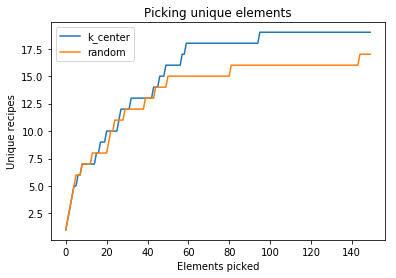

In [26]:
x = [i for i in range(elements_to_pick)]

plt.plot(x, k_center_number, label='k_center')
plt.plot(x, random_number, label='random')

plt.xlabel('Elements picked')
plt.ylabel('Unique recipes')

plt.title("Picking unique elements")

plt.legend()

plt.show()

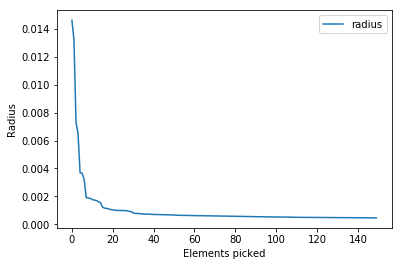

In [27]:
x = [i for i in range(150)]

plt.plot(x, radius, label='radius')
plt.xlabel('Elements picked')
plt.ylabel('Radius')
plt.legend()
plt.show()

In [28]:
from sklearn import metrics

In [64]:
def calculate_ARI(dataset, centers, labels):
    dict_labels = {}
    ii = 0
    for x in set(labels):
        if x not in dict_labels:
            dict_labels[x] = ii
            ii = ii+1
    true_labels = [dict_labels[x] for x in labels]
    found_labels = []
    for x in dataset:
        j = np.argmin([euclidean(x,c) for c in centers])
        found_labels.append(j)
    print(true_labels)
    print(found_labels)
    return [metrics.adjusted_rand_score(true_labels, found_labels),metrics.adjusted_mutual_info_score(true_labels,found_labels)]
    

In [65]:
p_centers = [ train_embedding[i] for i in centers[0:10]]